In [74]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.transpiler import CouplingMap
from qiskit.converters import dag_to_circuit
from qiskit.transpiler.layout import Layout
import numpy as np
from qiskit.transpiler.passes import Unroller
from qiskit.transpiler.passes import (
    TrivialLayout,
    BasicSwap,
    ApplyLayout,
    SetLayout,
    SabreLayout,
    FullAncillaAllocation,
    EnlargeWithAncilla,
)
from qiskit.transpiler.passmanager import PassManager

# from virtual_swap.cns_sabre import CNS_SabreSwap
from virtual_swap.cns_sabrev2 import CNS_SabreSwapV2 as CNS_SabreSwap

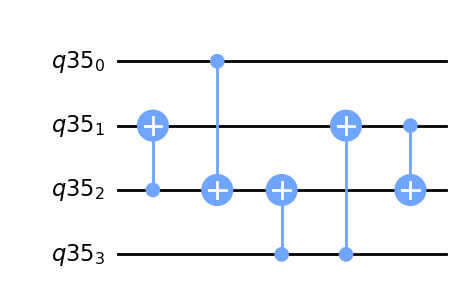

In [75]:
# load a dummy circuit
# generate network of random cnots
n, M = 2, 5
N = n**2
register = QuantumRegister(N)
qc = QuantumCircuit(register)

for _ in range(M):
    qc.cx(*np.random.choice(N, 2, replace=False))
qc.decompose().draw("mpl")

In [76]:
# N =3
# register = QuantumRegister(N)
# qc = QuantumCircuit(register)
# qc.ccx(0,1,2)
# qc = qc.decompose()
# qc.draw("mpl")

In [77]:
# load a dummy coupling map and layout
coupling = CouplingMap.from_line(N)
layout = Layout({q: i for q, i in zip(register, range(N))})

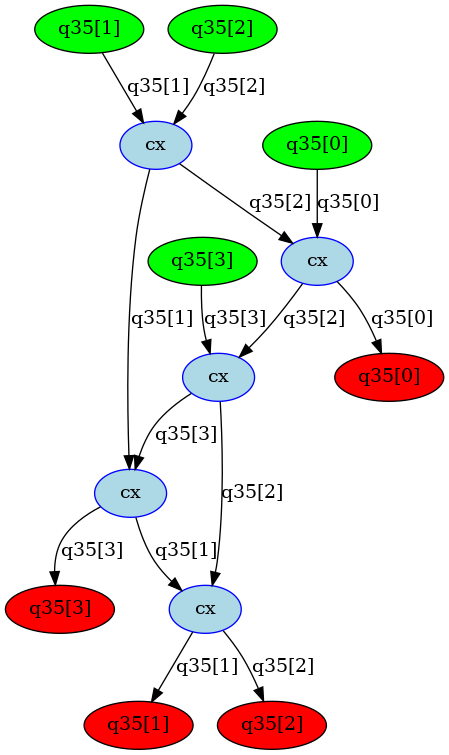

In [78]:
# print DAG
from qiskit.converters import circuit_to_dag

dag = circuit_to_dag(qc)
dag.draw("mpl")

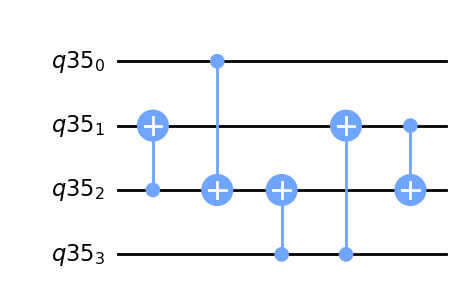

In [79]:
qc.draw("mpl")

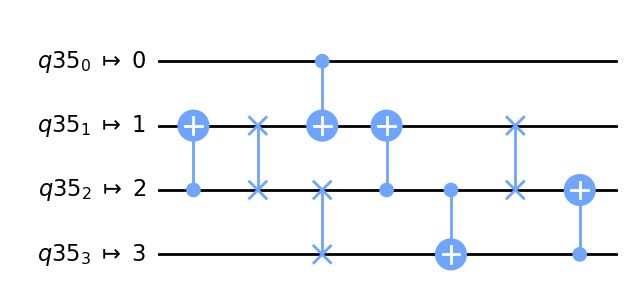

In [80]:
from qiskit import transpile

qiskit_qc = transpile(
    qc, coupling_map=coupling, initial_layout=layout, optimization_level=3
)
qiskit_qc.draw("mpl")

[DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(4, 'q'), 2), Qubit(QuantumRegister(4, 'q'), 1)), cargs=())]
[DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 2)), cargs=())]
[DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(4, 'q'), 3), Qubit(QuantumRegister(4, 'q'), 2)), cargs=())]
[DAGOpNode(op=Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]), qargs=(Qubit(QuantumRegister(4, 'q'), 3), Qubit(QuantumRegister(4, 'q'), 1)), cargs=())]
3


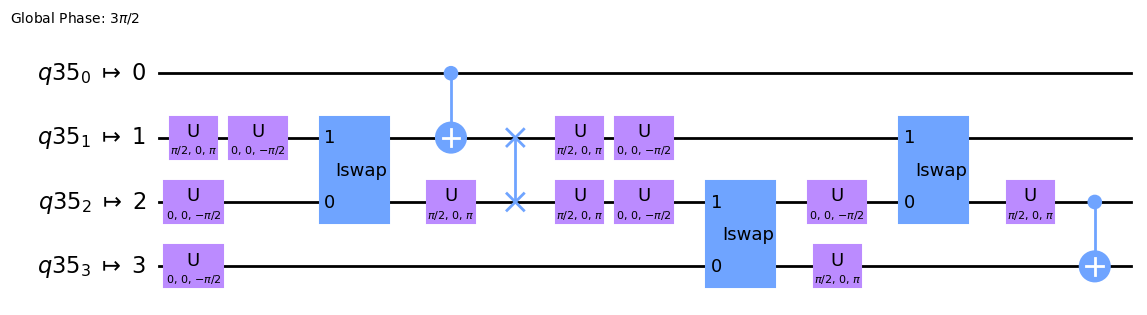

In [81]:
# make sure the old sabre python code works with our new qiskit version
pm = PassManager()
pm.append(Unroller(["u", "cx", "iswap", "swap"]))
routing = CNS_SabreSwap(coupling, heuristic="lookahead")
# pm.append(SabreLayout(coupling, routing_pass=routing))
# pm.append(TrivialLayout(coupling))
pm.append(SetLayout(layout))
pm.append([FullAncillaAllocation(coupling), EnlargeWithAncilla(), ApplyLayout()])
pm.append(routing)
pm.append(Unroller(["u", "cx", "iswap", "swap"]))
qc_swapped = pm.run(qc)
print(pm.property_set["accept_subs"])
qc_swapped.draw("mpl")

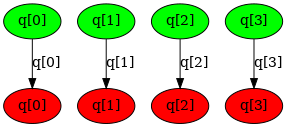

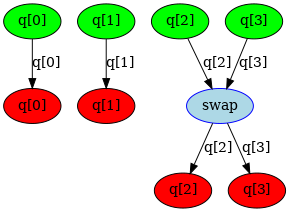

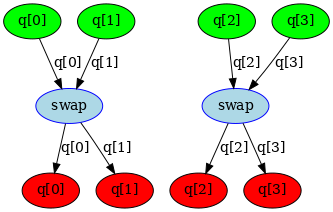

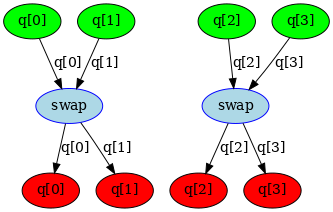

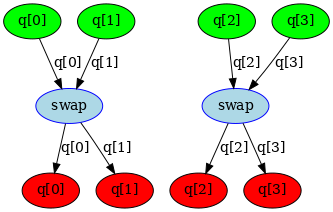

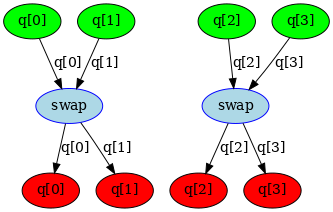

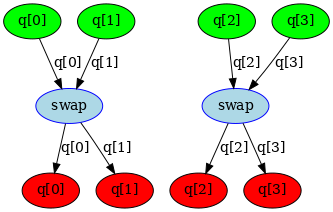

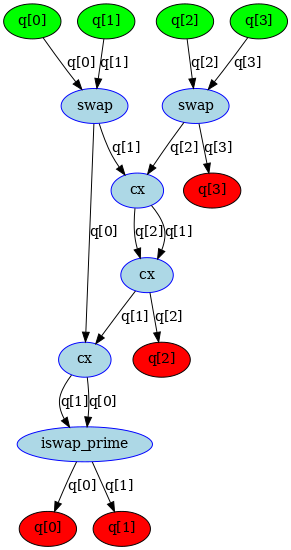

In [73]:
snapshots = pm.property_set["mapped_dag_snaps"]
for snap in snapshots:
    display(snap)